# Setup

Dependencies:
- System: python3
- Python: jupyter, numpy, matplotlib, scipy, ipywidgets

Example setup for a Ubuntu system (Mac users, maybe `brew` instead of `sudo apt`; Windows users, learn to love [WSL](https://docs.microsoft.com/en-us/windows/wsl/install-win10)):
```
/usr/bin/python3 -m pip install --upgrade pip
pip install --upgrade jupyter numpy matplotlib scipy ipywidgets
jupyter notebook  # from the directory of this notebook
```
Alternatively, view this notebook on [Google Colab](https://colab.research.google.com/github/PrinciplesofRobotAutonomy/AA274A_Examples/blob/master/Lecture_3/Planar%20Quadrotor%20Trajectory%20Planning.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from ipywidgets import interact

# Plotting Code

In [2]:
"""
Planar quadrotor animation using `matplotlib`.
Author: Spencer M. Richards
        Autonomous Systems Lab (ASL), Stanford
        (GitHub: spenrich)
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.animation as animation


def animate_planar_quad(t, x, y, θ, title_string=None, display_in_notebook=False):
    """Animate the planar quadrotor system from given position data.
    All arguments are assumed to be 1-D NumPy arrays, where `x`, `y`, and `θ`
    are the degrees of freedom of the planar quadrotor over time `t`.
    Example usage:
        import matplotlib.pyplot as plt
        from animations import animate_planar_quad
        fig, ani = animate_planar_quad(t, x, θ)
        ani.save('planar_quad.mp4', writer='ffmpeg')
        plt.show()
    """
    # Geometry
    rod_width = 2.
    rod_height = 0.15
    axle_height = 0.2
    axle_width = 0.05
    prop_width = 0.5 * rod_width
    prop_height = 1.5 * rod_height
    hub_width = 0.3 * rod_width
    hub_height = 2.5 * rod_height

    # Figure and axis
    fig, ax = plt.subplots(dpi=100)
    x_min, x_max = np.min(x), np.max(x)
    x_pad = (rod_width + prop_width) / 2 + 0.1 * (x_max - x_min)
    y_min, y_max = np.min(y), np.max(y)
    y_pad = (rod_width + prop_width) / 2 + 0.1 * (y_max - y_min)
    ax.set_xlim([x_min - x_pad, x_max + x_pad])
    ax.set_ylim([y_min - y_pad, y_max + y_pad])
    ax.set_aspect(1.)
    if title_string is not None:
        plt.title(title_string)

    # Artists
    rod = mpatches.Rectangle((-rod_width / 2, -rod_height / 2),
                             rod_width,
                             rod_height,
                             facecolor='tab:blue',
                             edgecolor='k')
    hub = mpatches.FancyBboxPatch((-hub_width / 2, -hub_height / 2),
                                  hub_width,
                                  hub_height,
                                  facecolor='tab:blue',
                                  edgecolor='k',
                                  boxstyle='Round,pad=0.,rounding_size=0.05')
    axle_left = mpatches.Rectangle((-rod_width / 2, rod_height / 2),
                                   axle_width,
                                   axle_height,
                                   facecolor='tab:blue',
                                   edgecolor='k')
    axle_right = mpatches.Rectangle((rod_width / 2 - axle_width, rod_height / 2),
                                    axle_width,
                                    axle_height,
                                    facecolor='tab:blue',
                                    edgecolor='k')
    prop_left = mpatches.Ellipse(((axle_width - rod_width) / 2, rod_height / 2 + axle_height),
                                 prop_width,
                                 prop_height,
                                 facecolor='tab:gray',
                                 edgecolor='k',
                                 alpha=0.7)
    prop_right = mpatches.Ellipse(((rod_width - axle_width) / 2, rod_height / 2 + axle_height),
                                  prop_width,
                                  prop_height,
                                  facecolor='tab:gray',
                                  edgecolor='k',
                                  alpha=0.7)
    patches = (rod, hub, axle_left, axle_right, prop_left, prop_right)
    for patch in patches:
        ax.add_patch(patch)
    trace = ax.plot([], [], '--', linewidth=2, color='tab:orange')[0]
    timestamp = ax.text(0.1, 0.9, '', transform=ax.transAxes)

    def animate(k, t, x, y, θ):
        transform = mtransforms.Affine2D().rotate_around(0., 0., θ[k])
        transform += mtransforms.Affine2D().translate(x[k], y[k])
        transform += ax.transData
        for patch in patches:
            patch.set_transform(transform)
        trace.set_data(x[:k + 1], y[:k + 1])
        timestamp.set_text('t = {:.1f} s'.format(t[k]))
        artists = patches + (trace, timestamp)
        return artists

    dt = t[1] - t[0]
    step = max(int(np.floor((1 / 30) / dt)), 1)  # max out at 30Hz for faster rendering
    ani = animation.FuncAnimation(fig,
                                  animate,
                                  t[::step].size,
                                  fargs=(t[::step], x[::step], y[::step], θ[::step]),
                                  interval=step * dt * 1000,
                                  blit=True)
    if display_in_notebook:
        try:
            get_ipython()
            from IPython.display import HTML
            ani = HTML(ani.to_html5_video())
        except (NameError, ImportError):
            raise RuntimeError("`display_in_notebook = True` requires this code to be run in jupyter/colab.")
    plt.close(fig)
    return ani

# Problem Definition

In [3]:
class PlanarQuadrotorDynamics:

    def __init__(self):
        # Dynamics constants
        # yapf: disable
        self.g = 9.807         # gravity (m / s**2)
        self.m = 2.5           # mass (kg)
        self.l = 1.0           # half-length (m)
        self.I_zz = 1.0         # moment of inertia about the out-of-plane axis (kg * m**2)
        # yapf: enable

    def __call__(self, state, control):
        """Continuous-time dynamics of a planar quadrotor expressed as an ODE."""
        x, v_x, y, v_y, ϕ, ω = state
        T_1, T_2 = control
        return np.array([
            v_x,
            -(T_1 + T_2) * np.sin(ϕ) / self.m,
            v_y,
            (T_1 + T_2) * np.cos(ϕ) / self.m - self.g,
            ω,
            (T_2 - T_1) * self.l / self.I_zz,
        ])

In [4]:
dynamics = PlanarQuadrotorDynamics()
state_0 = np.array([4., 2., 6., 2., -np.pi / 4, -1.])
state_f = np.zeros(6)
t_f = 3  # fixed final time

# Direct Method

In [5]:
N = 60
dt = t_f / N

cost = lambda z: dt * np.sum(np.square(z.reshape(N + 1, 8)[:, -2:]))


def constraints(z):
    states_and_controls = z.reshape(N + 1, 8)
    states = states_and_controls[:, :6]
    controls = states_and_controls[:, -2:]
    constraint_list = [states[0] - state_0, states[-1] - state_f]
    for i in range(N):
        constraint_list.append(states[i + 1] - (states[i] + dt * dynamics(states[i], controls[i])))
    return np.concatenate(constraint_list)


z_guess = np.concatenate([np.linspace(state_0, state_f, N + 1), np.ones((N + 1, 2))], -1).ravel()
z_iterates = [z_guess]
result = minimize(cost,
                  z_guess,
                  constraints={
                      'type': 'eq',
                      'fun': constraints
                  },
                  options={'maxiter': 1000},
                  callback=lambda z: z_iterates.append(z))
z_iterates = np.stack(z_iterates)
result

     fun: 1149.8288095969094
     jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.84649658e+00,  8.35205078e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.68554688e+00,  5.97290039e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -1.38005066e+00,  4.29351807e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -9.60403442e-01,  3.25469971e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -4.63806152e-01,  2.84454346e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  6.33697510e-02,  3.02307129e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.

In [6]:
t = np.linspace(0, t_f, N + 1)
z = result.x.reshape(N + 1, 8)
animate_planar_quad(t, z[:, 0], z[:, 2], z[:, 4], display_in_notebook=True)

In [7]:
t = np.linspace(0, t_f, N + 1)
@interact(iteration=(0, len(z_iterates) - 1))
def f(iteration=0):
    z = z_iterates[iteration].reshape(N + 1, 8)
    return animate_planar_quad(t, z[:, 0], z[:, 2], z[:, 4], display_in_notebook=True)

interactive(children=(IntSlider(value=0, description='iteration', max=41), Output()), _dom_classes=('widget-in…

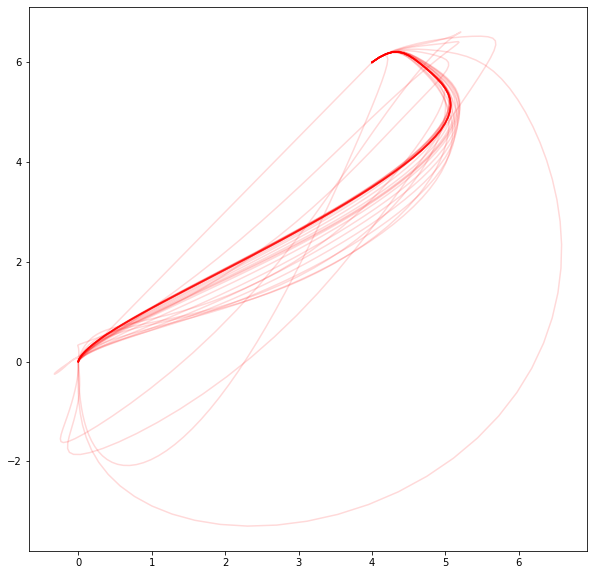

In [8]:
states_and_controls_iterates = z_iterates.reshape(-1, N + 1, 8)
plt.figure(figsize=(10, 10))
plt.plot(states_and_controls_iterates[:, :, 0].T, states_and_controls_iterates[:, :, 2].T, color='red', alpha=0.15);

# Differential Flatness

In [9]:
from numpy.polynomial import Polynomial

In [10]:
def get_flat_output_derivatives(state, ydd=0, yddd=0, g=dynamics.g):
    x, xd, y, yd, ϕ, ω = state
    xdd = -(ydd + g) * np.tan(ϕ)
    xddd = -(ω * ((ydd + g)**2 + xdd**2) - yddd * xdd) / (ydd + g)
    return np.array([x, xd, xdd, xddd]), np.array([y, yd, ydd, yddd])

In [11]:
basis_functions = [Polynomial.basis(i) for i in range(8)]
basis_matrix = np.array([[ψ.deriv(d)(0) for ψ in basis_functions] for d in range(4)] +
                        [[ψ.deriv(d)(t_f) for ψ in basis_functions] for d in range(4)])

In [12]:
x_poly = Polynomial(
    np.linalg.solve(basis_matrix,
                    np.concatenate([get_flat_output_derivatives(state_0)[0],
                                    get_flat_output_derivatives(state_f)[0]])))
y_poly = Polynomial(
    np.linalg.solve(basis_matrix,
                    np.concatenate([get_flat_output_derivatives(state_0)[1],
                                    get_flat_output_derivatives(state_f)[1]])))

In [13]:
x_poly

Polynomial([  4.        ,   2.        ,   4.9035    ,   3.269     ,
       -13.01687654,   8.30538272,  -2.07273594,   0.18508871], domain=[-1,  1], window=[-1,  1])

In [14]:
y_poly

Polynomial([ 6.00000000e+00,  2.00000000e+00, -3.31586610e-14,  0.00000000e+00,
       -4.07407407e+00,  3.18518519e+00, -8.72427984e-01,  8.23045267e-02], domain=[-1,  1], window=[-1,  1])

In [15]:
t = np.linspace(0, t_f, 30 * t_f)
animate_planar_quad(t,
                    x_poly(t),
                    y_poly(t),
                    np.arctan2(-x_poly.deriv(2)(t),
                               y_poly.deriv(2)(t) + dynamics.g),
                    display_in_notebook=True)